In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

2024-11-22 09:41:47.529684: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 09:41:47.529796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 09:41:47.532016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 09:41:47.545822: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 09:41:49.310671: W tensorflow/compiler/tf2

In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpus

2024-11-22 09:41:53.352332: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-22 09:41:53.409888: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-22 09:41:53.410351: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-11-22 09:41:53.429594: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-22 09:41:53.430099: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-22 09:41:53.430509: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
dataset_path = "./3dfailedprints"
batch_size = 32
img_height = 120
img_width = 192
seed = 1

# Simple model

Dense neural network with 32 neurons in hidden layer one input layer, and one ouput layer.

In [5]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dataset_path,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset="training",
    crop_to_aspect_ratio=True,
    seed=seed,
    label_mode="binary",
)

Found 1855 files belonging to 2 classes.
Using 1484 files for training.


In [6]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dataset_path,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset="validation",
    crop_to_aspect_ratio=True,
    seed=seed,
    label_mode="binary",
)

Found 1855 files belonging to 2 classes.
Using 371 files for validation.


In [7]:
class_names = training_ds.class_names
print(class_names)

['ok', 'spaghetti']


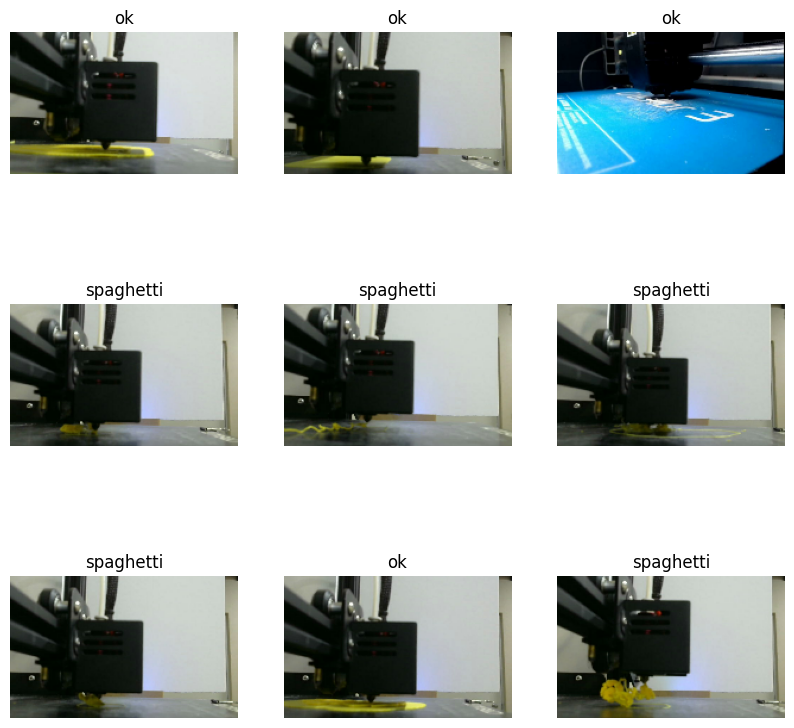

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

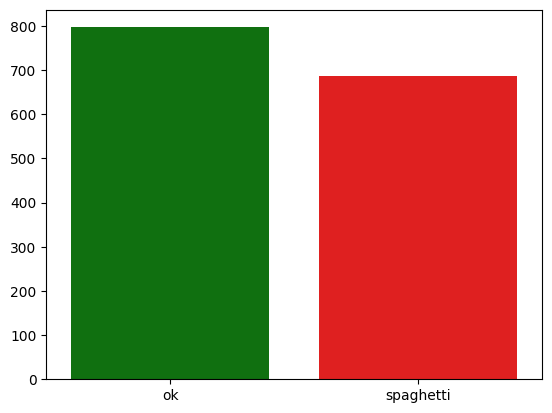

In [9]:
counts = {
    "ok": 0,
    "spaghetti": 0,
}

for images, labels in training_ds.apply(tf.data.Dataset.unbatch).as_numpy_iterator():
    for label in labels:
        if label > 0.5:
            counts["spaghetti"] += 1
        else:
            counts["ok"] += 1

sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette=['green', 'red'])

In [10]:
# balance dataset
ok = training_ds.unbatch().filter(lambda x, y: tf.equal(y, 0.0)[0])
spaghetti = training_ds.unbatch().filter(lambda x, y: tf.equal(y, 1.0)[0])

count_ok = ok.reduce(0, lambda x, _: x + 1).numpy()
count_spaghetti = spaghetti.reduce(0, lambda x, _: x + 1).numpy()

min_count = min(count_ok, count_spaghetti)

class_ok = ok.shuffle(buffer_size=count_ok).take(min_count)
class_spaghetti = spaghetti.shuffle(buffer_size=count_spaghetti).take(min_count)

balanced_train_ds = class_ok.concatenate(class_spaghetti)
balanced_train_ds = balanced_train_ds.shuffle(buffer_size=min_count * 2)
balanced_train_ds = balanced_train_ds.batch(32)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

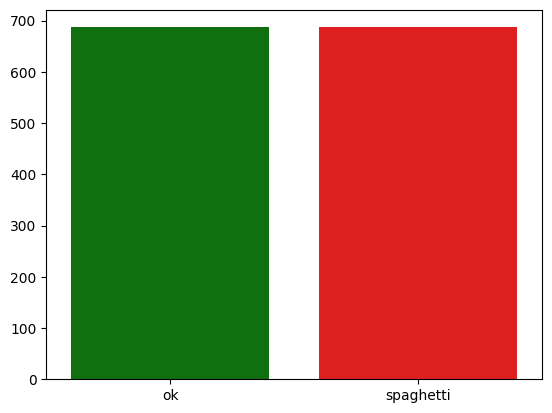

In [11]:
counts = {
    "ok": 0,
    "spaghetti": 0,
}

for images, labels in balanced_train_ds.as_numpy_iterator():
    for label in labels:
        if label > 0.5:
            counts["spaghetti"] += 1
        else:
            counts["ok"] += 1
            
sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette=['green', 'red'])

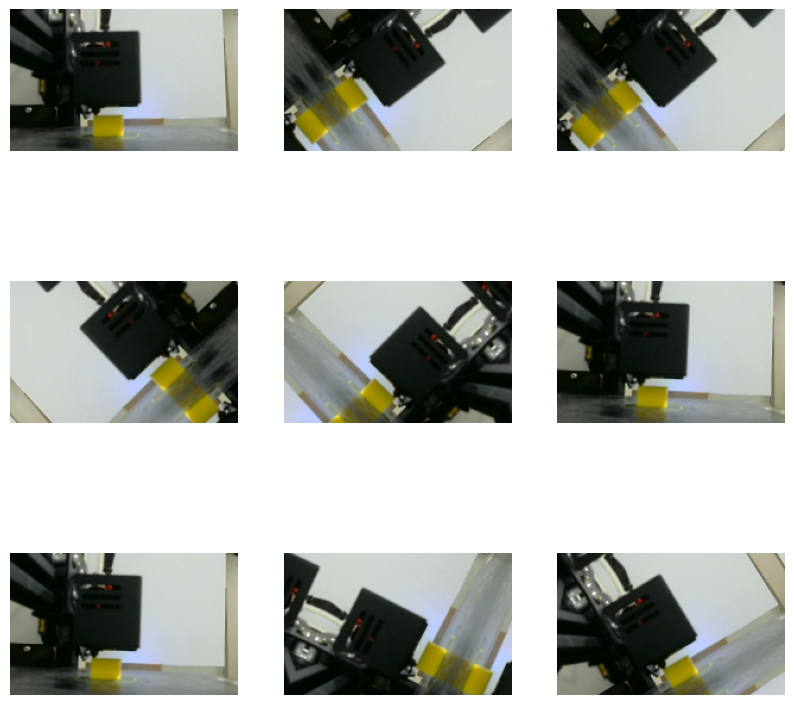

In [12]:
data_augmenter = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.GaussianNoise(0.1),
])

for image, _ in training_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmenter(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
balanced_train_ds = balanced_train_ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmenter(inputs)
x = tf.keras.layers.Flatten(input_shape=(img_height, img_width, 3))(inputs)
x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='HeNormal')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='HeNormal')(x)

small_model = tf.keras.Model(inputs, outputs)

small_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.F1Score(threshold=0.5),
        tf.keras.metrics.BinaryAccuracy(),
    ]
)

small_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 192, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 69120)             0         
                                                                 
 dense (Dense)               (None, 32)                2211872   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2211905 (8.44 MB)
Trainable params: 2211905 (8.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
!apt update && apt upgade -y
!apt install -y graphviz
!pip install pydot

Get:1 file:/var/cuda-repo-ubuntu2204-12-0-local  InRelease [1575 B]
Get:1 file:/var/cuda-repo-ubuntu2204-12-0-local  InRelease [1575 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:6 https://deb.nodesource.com/node_20.x nodistro InRelease [12.1 kB]        
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:8 https://packagecloud.io/github/git-lfs/ubuntu jammy InRelease [29.2 kB]  
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2734 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1512 kB]
Get:12 http://archive.ub

In [16]:
tf.keras.utils.plot_model(small_model, to_file="small_model.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
small_base_path = "/notebooks/weights/small_training_1/"
checkpoint_path = small_base_path + "cp.weights.h5"
small_history_path = small_base_path + "history.npy"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)
small_history = small_model.fit(balanced_train_ds, epochs=100, validation_data=test_ds, callbacks=[cp_callback])
small_history = small_history.history

Epoch 1/100


2024-11-22 09:42:47.688542: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8bbfa15320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-22 09:42:47.688615: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2024-11-22 09:42:47.699968: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-22 09:42:48.422628: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1732268568.583045      98 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     39/Unknown - 11s 12ms/step - loss: 762.1174 - precision: 0.5851 - recall: 0.3935 - f1_score: 0.4706 - binary_accuracy: 0.5601

2024-11-22 09:42:49.548802: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2312401940866293777
2024-11-22 09:42:49.548908: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8277958272586193803
2024-11-22 09:42:49.548970: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10334320191232853910



Epoch 1: val_loss improved from inf to 0.68481, saving model to /notebooks/weights/small_training_1/cp.weights.h5
43/43 [==============================] - 14s 67ms/step - loss: 692.2913 - precision: 0.5851 - recall: 0.3552 - f1_score: 0.4420 - binary_accuracy: 0.5517 - val_loss: 0.6848 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_binary_accuracy: 0.5067
Epoch 2/100
40/43 [==========================>...] - ETA: 0s - loss: 0.6148 - precision: 0.6218 - recall: 0.8041 - f1_score: 0.7013 - binary_accuracy: 0.6586      
Epoch 2: val_loss improved from 0.68481 to 0.53196, saving model to /notebooks/weights/small_training_1/cp.weights.h5
43/43 [==============================] - 6s 38ms/step - loss: 0.6109 - precision: 0.6250 - recall: 0.8079 - f1_score: 0.7048 - binary_accuracy: 0.6616 - val_loss: 0.5320 - val_precision: 0.7512 - val_recall: 0.8415 - val_f1_score: 0.7938 - val_binary_accuracy: 0.7844
Epoch 3/100
42/43 [============================>.] -

In [18]:
small_model_scoring = small_model.evaluate(test_ds, verbose=2)

print('\nTest loss:', small_model_scoring[0])
print('\nTest accuracy:', small_model_scoring[4])
print('\nTest precision:', small_model_scoring[1])
print('\nTest recall:', small_model_scoring[2])
print('\nTest F1:', small_model_scoring[3])

12/12 - 1s - loss: 0.6932 - precision: 0.4933 - recall: 1.0000 - f1_score: 0.6606 - binary_accuracy: 0.4933 - 849ms/epoch - 71ms/step

Test loss: 0.6931656002998352

Test accuracy: 0.493261456489563

Test precision: 0.493261456489563

Test recall: 1.0

Test F1: [0.66064984]


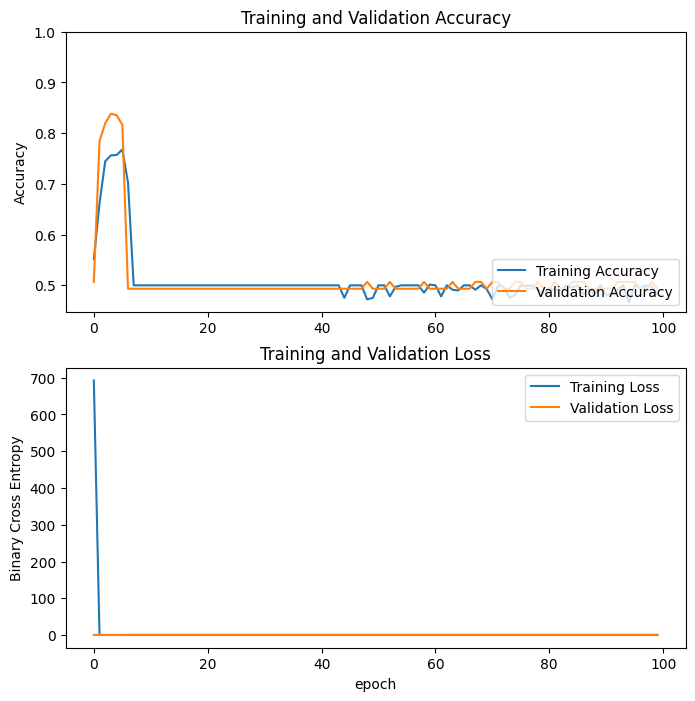

In [19]:
small_acc = small_history['binary_accuracy']
small_val_acc = small_history['val_binary_accuracy']

small_loss = small_history['loss']
small_val_loss = small_history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(small_acc, label='Training Accuracy')
plt.plot(small_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(small_loss, label='Training Loss')
plt.plot(small_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

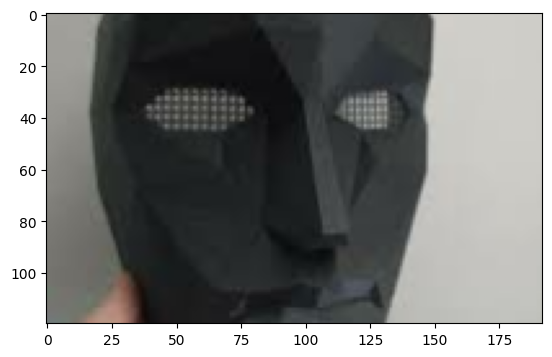

(120, 192, 3)
1/1 [==============================] - 0s 135ms/step
got: spaghetti
should be: ok


In [20]:
for images, labels in test_ds.take(1).as_numpy_iterator():
    plt.imshow(images[0] / 255)
    plt.show()
    print(images[0].shape)
    got = small_model.predict(np.array([images[0]]))

    if got > 0.5:
        print("got: spaghetti")
    else:
        print("got: ok")

    if labels[0] == 1.:
        print("should be: spaghetti")
    else:
        print("should be: ok")
    break


# Medium model: custom CNN

In [21]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmenter(inputs)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='HeNormal')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='HeNormal')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='HeNormal')(x)

medium_model = tf.keras.Model(inputs, outputs)

medium_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.F1Score(threshold=0.5, average=None),
        tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy'),
    ]
)

medium_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 192, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 120, 192, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 118, 190, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 95, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 93, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 46, 64)        0         
 g2D)                                                      

In [22]:
medium_base_path = "/notebooks/weights/medium_training_1/"
checkpoint_path = medium_base_path + "cp.weights.h5"
medium_history_path = medium_base_path + "history.npy"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)
medium_history = medium_model.fit(balanced_train_ds, epochs=100, validation_data=test_ds, callbacks=[cp_callback])
medium_history = medium_history.history

Epoch 1/100
     43/Unknown - 17s 65ms/step - loss: 3.3595 - precision_1: 0.5451 - recall_1: 0.5721 - f1_score: 0.5582 - accuracy: 0.5473
Epoch 1: val_loss improved from inf to 0.63369, saving model to /notebooks/weights/medium_training_1/cp.weights.h5
43/43 [==============================] - 20s 123ms/step - loss: 3.3595 - precision_1: 0.5451 - recall_1: 0.5721 - f1_score: 0.5582 - accuracy: 0.5473 - val_loss: 0.6337 - val_precision_1: 0.7458 - val_recall_1: 0.2404 - val_f1_score: 0.3636 - val_accuracy: 0.5849
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.6702 - precision_1: 0.6036 - recall_1: 0.5852 - f1_score: 0.5942 - accuracy: 0.6004
Epoch 2: val_loss did not improve from 0.63369
43/43 [==============================] - 6s 52ms/step - loss: 0.6702 - precision_1: 0.6036 - recall_1: 0.5852 - f1_score: 0.5942 - accuracy: 0.6004 - val_loss: 0.6515 - val_precision_1: 0.7417 - val_recall_1: 0.4863 - val_f1_score: 0.5875 - val_accuracy: 0.6631
Epoch 3/100
43/43 [

In [23]:
medium_model_scoring = medium_model.evaluate(test_ds, verbose=2)

print('\nTest accuracy:', medium_model_scoring[4])
print('\nTest precision:', medium_model_scoring[1])
print('\nTest recall:', medium_model_scoring[2])
print('\nTest F1:', medium_model_scoring[3])

12/12 - 1s - loss: 0.1533 - precision_1: 0.9351 - recall_1: 0.9454 - f1_score: 0.9402 - accuracy: 0.9407 - 814ms/epoch - 68ms/step

Test accuracy: 0.9407008290290833

Test precision: 0.9351351261138916

Test recall: 0.9453551769256592

Test F1: [0.9402174]


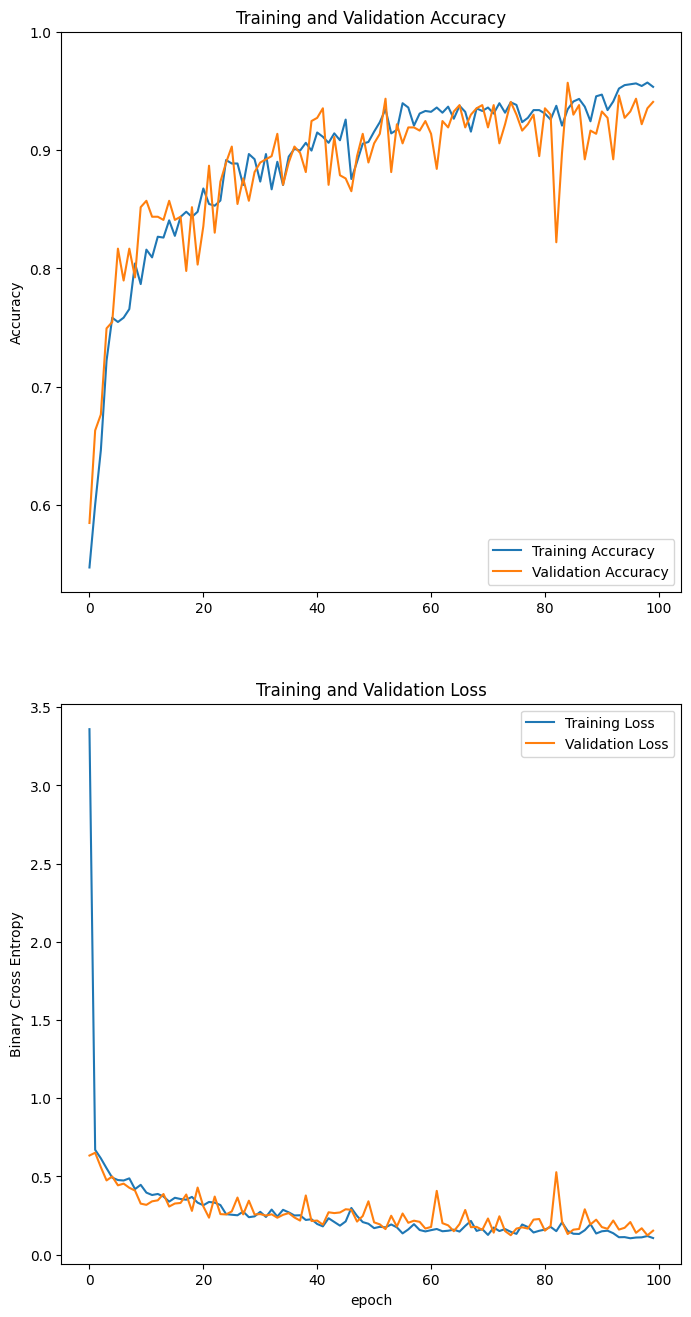

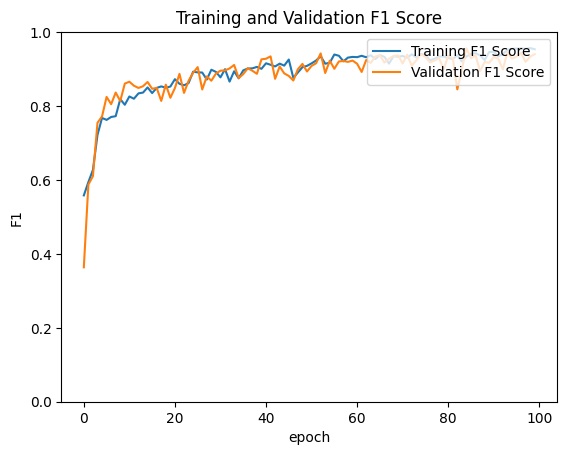

In [27]:
medium_acc = medium_history['accuracy']
medium_val_acc = medium_history['val_accuracy']

medium_loss = medium_history['loss']
medium_val_loss = medium_history['val_loss']

plt.figure(figsize=(8, 16))
plt.subplot(2, 1, 1)
plt.plot(medium_acc, label='Training Accuracy')
plt.plot(medium_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(medium_loss, label='Training Loss')
plt.plot(medium_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

medium_f1 = medium_history['f1_score']
medium_val_f1 = medium_history['val_f1_score']

plt.subplot(1,1,1)
plt.plot(medium_f1, label='Training F1 Score ')
plt.plot(medium_val_f1, label='Validation F1 Score')
plt.legend(loc='upper right')
plt.ylabel('F1')
plt.ylim([0,1.0])
plt.title('Training and Validation F1 Score')
plt.xlabel('epoch')
plt.show()

# Large model: fine-tuning MobileNetV3

In [28]:
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(img_height, img_width, 3),
    include_top=False,
)

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmenter(inputs)
x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
x = base_model(x, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='HeNormal')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='HeNormal')(x)

large_model = tf.keras.Model(inputs, outputs)

large_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.F1Score(threshold=0.5),
        tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy'),
    ]
)

large_model.summary()

4334752/4334752 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 192, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 120, 192, 3)       0         
                                                                 
 MobilenetV3small (Function  (None, 4, 6, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_5 (Dense)             (None, 64)                36928     
                                                              

In [29]:
large_base_path = "/notebooks/weights/large_training_1/"
large_cp_path = large_base_path + "cp.weights.h5"
large_history_path = large_base_path + "history.npy"
checkpoint_dir = os.path.dirname(large_cp_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=large_cp_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)

large_history = large_model.fit(balanced_train_ds, epochs=100, validation_data=test_ds, callbacks=[cp_callback])
np.save(large_history_path, large_history.history)
large_history = large_history.history

Epoch 1/100
     43/Unknown - 55s 135ms/step - loss: 0.3318 - precision_2: 0.8350 - recall_2: 0.8472 - f1_score: 0.8410 - accuracy: 0.8399
Epoch 1: val_loss improved from inf to 0.15464, saving model to /notebooks/weights/large_training_1/cp.weights.h5
43/43 [==============================] - 61s 293ms/step - loss: 0.3318 - precision_2: 0.8350 - recall_2: 0.8472 - f1_score: 0.8410 - accuracy: 0.8399 - val_loss: 0.1546 - val_precision_2: 0.9817 - val_recall_2: 0.8798 - val_f1_score: 0.9280 - val_accuracy: 0.9326
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.1319 - precision_2: 0.9503 - recall_2: 0.9461 - f1_score: 0.9482 - accuracy: 0.9483
Epoch 2: val_loss improved from 0.15464 to 0.10628, saving model to /notebooks/weights/large_training_1/cp.weights.h5
43/43 [==============================] - 9s 122ms/step - loss: 0.1319 - precision_2: 0.9503 - recall_2: 0.9461 - f1_score: 0.9482 - accuracy: 0.9483 - val_loss: 0.1063 - val_precision_2: 0.9771 - val_recall_2: 

In [30]:
large_model_scoring = large_model.evaluate(test_ds, verbose=2)

print('\nTest accurancy:', large_model_scoring[4])
print('\nTest precision:', large_model_scoring[1])
print('\nTest recall:', large_model_scoring[2])
print('\nTest F1:', large_model_scoring[3])

12/12 - 1s - loss: 0.1042 - precision_2: 0.9888 - recall_2: 0.9672 - f1_score: 0.9779 - accuracy: 0.9784 - 1s/epoch - 83ms/step

Test accurancy: 0.9784366488456726

Test precision: 0.9888268113136292

Test recall: 0.9672130942344666

Test F1: [0.97790056]


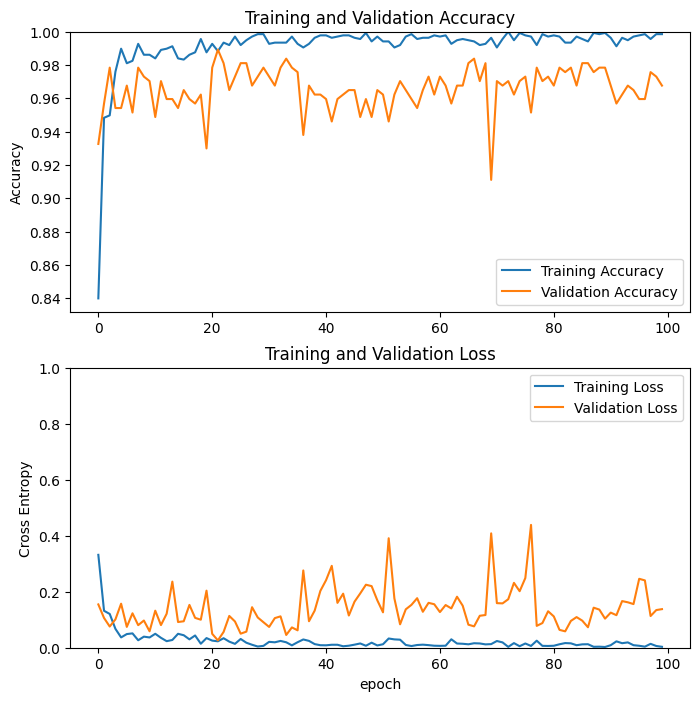

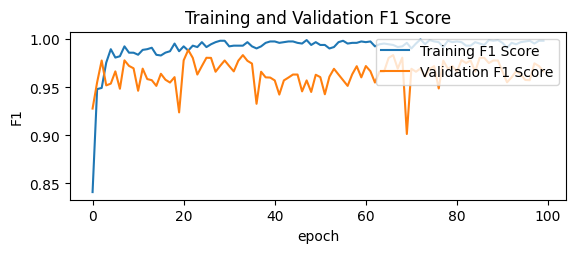

In [31]:
import matplotlib.pyplot as plt

medium_acc = large_history['accuracy']
medium_val_acc = large_history['val_accuracy']

medium_loss = large_history['loss']
medium_val_loss = large_history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(medium_acc, label='Training Accuracy')
plt.plot(medium_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(medium_loss, label='Training Loss')
plt.plot(medium_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

medium_f1 = large_history['f1_score']
medium_val_f1 = large_history['val_f1_score']

plt.subplot(2, 1, 2)
plt.plot(medium_f1, label='Training F1 Score ')
plt.plot(medium_val_f1, label='Validation F1 Score')
plt.legend(loc='upper right')
plt.ylabel('F1')
plt.title('Training and Validation F1 Score')
plt.xlabel('epoch')
plt.show()

In [32]:
score_table = [
    small_model_scoring,
    medium_model_scoring,
    large_model_scoring,
]

results = pd.DataFrame(score_table, columns=["Loss", "Precision", "Recall", "F1", "Accuracy"])
results

,Loss,Precision,Recall,F1,Accuracy
0,0.693166,0.493261,1.000000,[0.66064984],0.493261
1,0.153329,0.935135,0.945355,[0.9402174],0.940701
2,0.104167,0.988827,0.967213,[0.97790056],0.978437


In [33]:
print(results.to_latex())

\begin{tabular}{lrrrlr}
\toprule
 & Loss & Precision & Recall & F1 & Accuracy \\
\midrule
0 & 0.693166 & 0.493261 & 1.000000 & [0.66064984] & 0.493261 \\
1 & 0.153329 & 0.935135 & 0.945355 & [0.9402174] & 0.940701 \\
2 & 0.104167 & 0.988827 & 0.967213 & [0.97790056] & 0.978437 \\
\bottomrule
\end{tabular}

